### Elevation trend analysis based on altimeter data.
### Content:
1. Icesat-1
- 1.1 Area weighted elevation differece and uncertainty estimation.
- 1.2 Write out the result.
2. Elevation change on the glacier region.
- 2.1 Result for overall setp region.
- 2.2 Result by tiles.
- 2.3 Result by bins
- 2.4 Write out the result.


In [2]:
import os 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils.tiles_bins_weighting import stat_bins_weighting, stat_tiles_weighting
from utils.tiles_bins_weighting import stat_bins_tiles_weighting, stat_tiles_bins_weighting
from utils.ransac_fitting import ransac_fitting


In [3]:
### Read in
path_sta_isat1 = 'data/icesat-1/stat_dif_isat1.nc'
path_sta_isat2 = 'data/icesat-2/stat_dif_isat2.nc'
### Write out
path_result_isat1 = 'data/icesat-1/result_isat1.nc'
path_result_isat2 = 'data/icesat-2/result_isat2.nc'


In [4]:
stat_isat1_xr = xr.open_dataset(path_sta_isat1)
stat_isat2_xr = xr.open_dataset(path_sta_isat2)
years_isat1, years_isat2 = stat_isat1_xr.years.values, stat_isat2_xr.years.values
bins_id_isat1, bins_id_isat2 = stat_isat1_xr.bins_id.values, stat_isat2_xr.bins_id.values
tiles_id = stat_isat2_xr.tiles_id.values


### 1. ICESAT-1 
#### 1.1 Area weighted elevation differece and robust linear fitting by ransac algorithm.


In [5]:
mean_binsWeighted_isat1, std_binsWeighted_isat1 = stat_bins_weighting(mean_bins=stat_isat1_xr['mean_glacier_bins'], \
                                    std_bins=stat_isat1_xr['std_glacier_bins'], glacier_area_bins=stat_isat1_xr['area_glacier_bins'])
mean_setp_glacier_isat1_cor = mean_binsWeighted_isat1.values - stat_isat1_xr['mean_stable_bins'].values   ### elevation change correction.
y_setp_glacier_isat1_filtered, y_setp_glacier_isat1_fitting, ransac_coef_setp_glacier_isat1 = ransac_fitting(x=np.arange(len(years_isat1)), y=mean_setp_glacier_isat1_cor, thre_mask=50)

### standard deviation of elevation change.
std_setp_glacier_isat1_cor = np.sqrt(np.square(std_binsWeighted_isat1.values) + np.square(stat_isat1_xr['std_stable_bins'].values)) 
print('Coefficient by icesat1:',ransac_coef_setp_glacier_isat1[0])


Coefficient by icesat1: -0.6862257027625939


#### 1.2 Uncertainty estimation

In [6]:
#### 1. Time interval: 2000-2021
epsilon = mean_setp_glacier_isat1_cor - y_setp_glacier_isat1_fitting
sigma_dh = np.std(epsilon)
sigma_dh_dt_isat1 = sigma_dh/len(years_isat1)
print('sigma_dh:', sigma_dh)
print('sigma_dh_dt of Icesat-1:', sigma_dh_dt_isat1)


sigma_dh: 3.07848684080312
sigma_dh_dt of Icesat-1: 0.4397838344004457


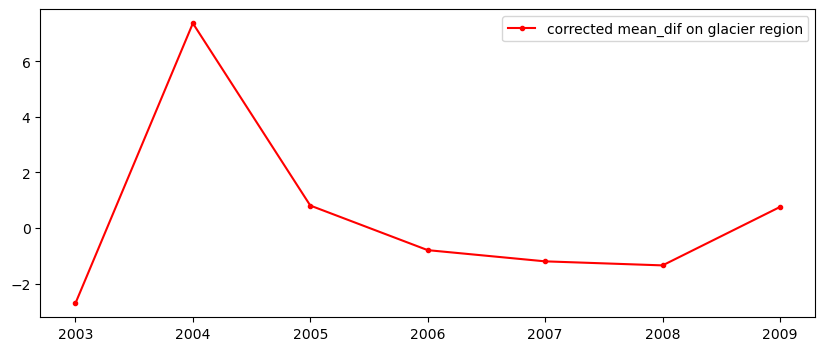

In [7]:
plt.figure(figsize=(10,4))
# plt.plot(years, stat_isat1_xr['mean_stable_bins'].values, '.-g', label='mean_dif on stable region')
# plt.plot(years, mean_binsWeighted_isat1, '.--b', label='mean_dif on glacier region')
plt.plot(years_isat1, mean_setp_glacier_isat1_cor, '.-r', label='corrected mean_dif on glacier region')
# plt.plot(years, y_fitting_setp_glacier_isat1, '.-r', label='corrected mean_dif fitting on glacier region')
plt.legend()



#### 1.3 Write out the result.

In [8]:
if os.path.exists(path_result_isat1): os.remove(path_result_isat1)
result_isat1_xr =xr.Dataset(
        {
        'area_glacier_bins': (["bins_id"], stat_isat1_xr['area_glacier_bins'].values),
        'ele_change_setp_cor': (["years"], mean_setp_glacier_isat1_cor),
        'ele_change_setp_cor_std': (["years"], std_setp_glacier_isat1_cor),
        'ele_change_setp_cor_fitting': (["years"], y_setp_glacier_isat1_fitting),
        'ele_rate_setp': ransac_coef_setp_glacier_isat1[0],
        'ele_rate_setp_error': sigma_dh_dt_isat1,
        },
        coords={'years': years_isat1,
                'bins_id': bins_id_isat1})

result_isat1_xr.to_netcdf(path_result_isat1)



### 2. ICESAT-2

#### 2.1 For the overall setp region.

In [9]:
mean_setp_stable_isat2, std_setp_stable_isat2 = stat_tiles_weighting(mean_tiles = stat_isat2_xr['mean_stable_tiles'], \
                                                                    std_tiles = stat_isat2_xr['std_stable_tiles'], 
                                                                    glacier_area_tiles = stat_isat2_xr['area_glacier_tiles'])
### From bins weighting to tiles weighting.
mean_tiles_glacier_isat2, std_tiles_glacier_isat2, mean_setp_glacier_isat2, std_setp_glacier_isat2 = \
                                                stat_bins_tiles_weighting(mean_tiles_bins=stat_isat2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_isat2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_isat2_xr['area_glacier_tiles_bins'])
#### elevation change correction
mean_setp_glacier_isat2_cor = mean_setp_glacier_isat2.values - mean_setp_stable_isat2.values
### standard deviation of the corercted elevation change.
std_setp_glacier_isat2_cor = np.sqrt(np.square(std_setp_stable_isat2.values) + np.square(std_setp_glacier_isat2.values)) 



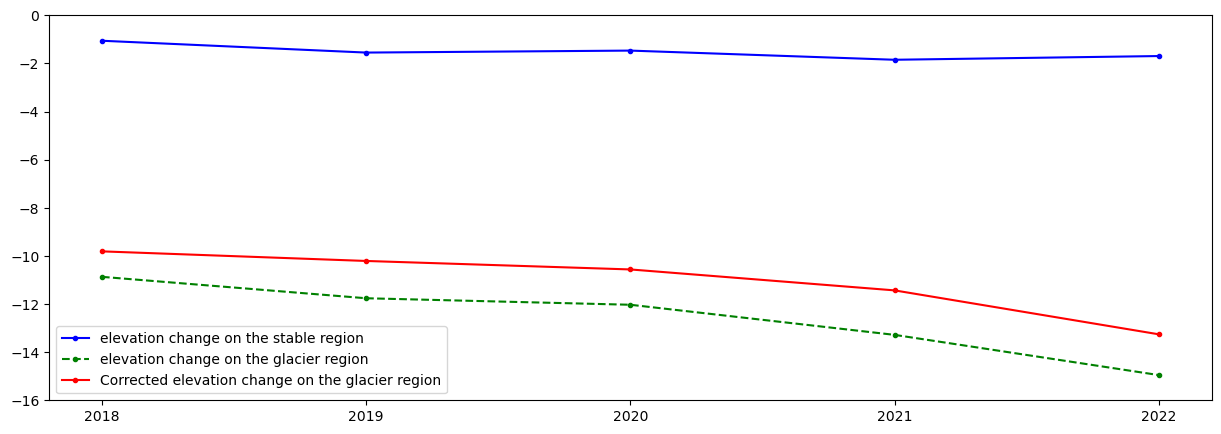

In [12]:
plt.figure(figsize=(15,5))
plt.plot(years_isat2, mean_setp_stable_isat2, '.-b', label='elevation change on the stable region')
plt.plot(years_isat2, mean_setp_glacier_isat2, '.--g', label='elevation change on the glacier region')   ### 
plt.plot(years_isat2, mean_setp_glacier_isat2_cor, '.-r', label='Corrected elevation change on the glacier region')   ### 
plt.ylim(top=0, bottom=-16)
plt.legend()



##### Robust linear fitting by ransac algorithm.

In [83]:
mean_filtered_setp_glacier_cor_isat2, mean_fitting_setp_glacier_cor_isat2, ransac_coef_setp_glacier_cor_isat2 \
                                        = ransac_fitting(x=np.arange(len(years_isat2)), y=mean_setp_glacier_isat2_cor, thre_mask=50)
print('coeffient by Icesat-2:', ransac_coef_setp_glacier_cor_isat2[0])



coeffient by Icesat-2: -0.5216873637877977


#### Uncertainty estimation


In [84]:
epsilon = mean_setp_glacier_isat2_cor - mean_fitting_setp_glacier_cor_isat2
sigma_dh = np.std(epsilon)
sigma_dh_dt_isat2 = sigma_dh/len(years_isat2)
# print('sigma_dh:', sigma_dh)
print('sigma_dh_dt of Icesat-2:', sigma_dh_dt_isat2)


sigma_dh_dt of Icesat-2: 0.11843029858462643


#### 2.2 Result by tiles.

In [85]:
ele_rate_tiles_isat2, ele_rate_tiles_error_isat2, mean_tile_glacier_isat2_cor = [], [], []
for tile_id in tiles_id:
  # tile_id =  'tile_27_98'
  mean_tile_glacier = mean_tiles_glacier_isat2.sel(tiles_id=tile_id).values
  mean_tile_stable = stat_isat2_xr['mean_stable_tiles'].sel(tiles_id = tile_id).values
  mean_tile_glacier_cor = mean_tile_glacier - mean_tile_stable    ### elevation change correction
  mean_tile_glacier_isat2_cor.append(mean_tile_glacier_cor)
  ids_valid = np.where(~np.isnan(mean_tile_glacier_cor))[0]
  if ids_valid.shape[0]>2:
    mean_tile_glacier_cor_filtered, mean_tile_glacier_cor_fitting, ransac_coef_tile_glacier_cor = \
                                                ransac_fitting(x=np.arange(len(years_isat2)), y=mean_tile_glacier_cor, thre_mask=50)
    ele_rate_tiles_isat2.append(ransac_coef_tile_glacier_cor[0])
    ## Uncertainty.
    epsilon = mean_tile_glacier_cor - mean_tile_glacier_cor_fitting
    sigma_dh = np.nanstd(epsilon)
    sigma_dh_dt = sigma_dh/len(years_isat2)
    ele_rate_tiles_error_isat2.append(sigma_dh_dt)
  else: 
    ele_rate_tiles_isat2.append(np.nan)
    ele_rate_tiles_error_isat2.append(np.nan)

mean_tile_glacier_isat2_cor = np.stack(mean_tile_glacier_isat2_cor, axis=0) 
mean_tile_glacier_isat2_cor.shape
  # break



(28, 5)

##### 2.3 Result by bins ( ! no correction)

In [66]:
### From bins weighting to tiles weighting.
mean_bins_glacier_isat2, std_bins_glacier_isat2, mean_setp_glacier_isat2, std_setp_glacier_isat2 = \
                                                stat_tiles_bins_weighting(mean_tiles_bins=stat_isat2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_isat2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_isat2_xr['area_glacier_tiles_bins'])
ele_rate_bins_isat2, ele_rate_bins_error_isat2, ele_change_bins = [], [], []

for bin_id in bins_id_isat2:
    ele_change_bin = mean_bins_glacier_isat2.sel(bins_id = bin_id).values
    ele_change_bin = np.where(ele_change_bin == 0, np.nan, ele_change_bin)
    ids_valid = np.where(~np.isnan(ele_change_bin))[0]
    if ids_valid.shape[0]>2:
        y_filtered_bin_glacier, y_fitting_bin_glacier, ransac_coef_bin_glacier = ransac_fitting(x=np.arange(len(years_isat2)), y=ele_change_bin, thre_mask=50)
        ele_rate_bins_isat2.append(ransac_coef_bin_glacier[0])
        ele_change_bins.append(ele_change_bin)
        ## Uncertainty.
        epsilon =  ele_change_bin - y_fitting_bin_glacier
        sigma_dh = np.nanstd(epsilon)
        sigma_dh_dt = sigma_dh/len(years_isat2)
        ele_rate_bins_error_isat2.append(sigma_dh_dt)
    else:
        ele_rate_bins_isat2.append(np.nan)
        ele_change_bins.append(np.nan)
        ele_rate_bins_error_isat2.append(np.nan)
area_glacier_bins = stat_isat2_xr['area_glacier_tiles_bins'].sum(dim='tiles_id').values


In [86]:
### 3) write out statistic of stable region to the xarray .nc file.
tiles_lat, tiles_lon = [], []
for tile_id in tiles_id:
    tiles_lat.append(int(tile_id[5:7]))
    tiles_lon.append(int(tile_id[8:]))
    
if os.path.exists(path_result_isat2): os.remove(path_result_isat2)
### Conver to xarray data.
result_isat2_xr =xr.Dataset(
        {
        'tiles_lat': (["tiles_id"], tiles_lat),
        'tiles_lon': (["tiles_id"], tiles_lon),
        "area_glacier_tiles": (["tiles_id"], stat_isat2_xr['area_glacier_tiles'].values),
        "area_glacier_bins": (["bins_id"], area_glacier_bins),
        "ele_change_setp_cor": (["years"], mean_setp_glacier_isat2_cor),
        "ele_change_setp_cor_fitting": (["years"], mean_fitting_setp_glacier_cor_isat2),
        "ele_change_setp_cor_std": (["years"], std_setp_glacier_isat2_cor),
        'ele_rate_setp': ransac_coef_setp_glacier_cor_isat2[0],
        'ele_rate_setp_error': sigma_dh_dt_isat2, 
        'ele_rate_tiles': (["tiles_id"], ele_rate_tiles_isat2),
        'ele_rate_tiles_error': (["tiles_id"], ele_rate_tiles_error_isat2),
        'ele_rate_bins': (["bins_id"], ele_rate_bins_isat2),
        'ele_rate_bins_error': (["bins_id"], ele_rate_bins_error_isat2), 
        },
        coords={'tiles_id': tiles_id,
                'bins_id': bins_id_isat2,
                'years': years_isat2})
# result_isat2_xr.to_netcdf(path_result_isat2)
